Importing all the liberaries

In [0]:
import tensorflow as tf

In [0]:
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as diaplay

In [0]:
import pathlib


Getting photos

In [4]:

data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', fname='flower_photos', untar=True)

228818944/228813984 [==============================] - 3s 0us/step


In [5]:
data_dir

'/root/.keras/datasets/flower_photos'

In [6]:
os.listdir(data_dir)

['roses', 'dandelion', 'daisy', 'sunflowers', 'tulips', 'LICENSE.txt']

In [0]:
CLASS_NAMES = [names for names in os.listdir(data_dir) if names != 'LICENSE.txt']

In [8]:
CLASS_NAMES

['roses', 'dandelion', 'daisy', 'sunflowers', 'tulips']

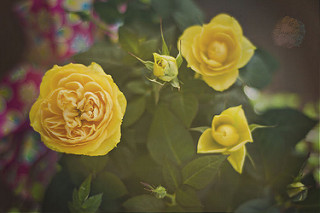

In [9]:
#displaying an image

import IPython.display as display

for tulips in os.listdir(os.path.join(data_dir, CLASS_NAMES[0])):
    display.display(Image.open(os.path.join(os.path.join(data_dir, CLASS_NAMES[0]), tulips)))
    break

In [0]:
list_ds = tf.data.Dataset.list_files(str(data_dir + '/*/*'))

In [11]:
for i in list_ds.take(5):
    print(i.numpy())

b'/root/.keras/datasets/flower_photos/roses/388405293_4db1d71f21_n.jpg'
b'/root/.keras/datasets/flower_photos/daisy/9299302012_958c70564c_n.jpg'
b'/root/.keras/datasets/flower_photos/roses/9633056561_6f1b7e8faf_m.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/4895122831_83db2ba2d0_n.jpg'
b'/root/.keras/datasets/flower_photos/tulips/434146736_310a42d9cb_m.jpg'


In [0]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
image_count = 3670
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)


def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label


def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep) # we can also use.....---->  parts = split('/')
    return parts[-2] == CLASS_NAMES


def decode_img(img):

    #decoding image to tensor
    img = tf.image.decode_jpeg(img, channels = 3)

    # conveting unit dtype to float32
    img = tf.image.convert_image_dtype(img, tf.float32)

    #resizing image
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    return img

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

labeled_ds = list_ds.map(process_path, num_parallel_calls = AUTOTUNE)

In [15]:
labeled_ds.take(5)

<TakeDataset shapes: ((224, 224, 3), (5,)), types: (tf.float32, tf.bool)>

In [16]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False False  True False False]


In [0]:
#preparing dataset for training

In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [0]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

TypeError: ignored

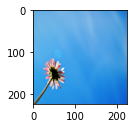

In [38]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [0]:
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))

In [41]:
timeit(train_ds)

....................................................................................................
1000 batches: 6.007784366607666 s
5326.42286 Images/s


In [42]:
#uncached dataset

uncached_ds = prepare_for_training(labeled_ds, cache=False)
timeit(uncached_ds)

....................................................................................................
1000 batches: 73.45027327537537 s
435.66890 Images/s


In [43]:
#making the cache file

filecache_ds = prepare_for_training(labeled_ds, cache="./flowers.tfcache")
timeit(filecache_ds)

....................................................................................................
1000 batches: 30.471242427825928 s
1050.17050 Images/s
